In [ ]:
from pipeline import Pipeline
from pipeline.steps import *
import logging
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

xgb_params = {
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 512,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbose": 0,
}

class FeatureEngineeringProductCatInteractionStep(PipelineStep):

    def __init__(self, cat="cat1", name: Optional[str] = None, tn="tn"):
        super().__init__(name)
        self.cat = cat
        self.tn = tn


    def execute(self, df, df_original=None) -> None:
        # agrupo el dataframe por cat1 (sumando), obteniendo fecha, cat1 y
        # luego paso el dataframe a wide format, donde cada columna es una categoria  y la fila es la suma de tn para cada cat1
        # luego mergeo al dataframe original por fecha y product_id
        df_index = df.index
        if df_original is None:
            df_to_proces = df
        else:
            df_to_proces = df_original
        df_cat = df_to_proces.groupby(["date_id", self.cat]).agg({self.tn: "sum"}).reset_index()
        print(df_cat)
        # cast column self.cat to string
        df_cat[self.cat] = df_cat[self.cat].astype(str)
        df_cat = df_cat.pivot(index="date_id", columns=self.cat, values=self.tn).reset_index()
        # paso a string los nombres de las columnas
        df_cat.columns = [f"{self.tn}_{self.cat}_{col}" if col != "date_id" else "date_id" for col in df_cat.columns]
        df = df.merge(df_cat, on="date_id", how="left")
        # vuelvo a setear el indice original
        df.index = df_index
        return {"df": df}
    

import numpy as np
class Log1pTranformation(PipelineStep):
    def execute(self, df):
        df["tn"] = df["tn"].apply(lambda x: np.log1p(x) if x >= 0 else 0)
        return {"df": df}
    
class InverseLog1pTranformation(PipelineStep):
    def execute(self, df, predictions, y_test):
        df["target"] = df["target"].apply(lambda x: np.expm1(x) if x >= 0 else 0)
        predictions = predictions.apply(lambda x: np.expm1(x) if x >= 0 else 0)
        y_test["target"] = y_test["target"].apply(lambda x: np.expm1(x) if x >= 0 else 0)
        return {"df": df, "predictions": predictions, "y_test": y_test}

class GroupByProductStep(PipelineStep):
    def execute(self, df) -> None:
        # Agrupo el dataframe por product_id y fecha, sumando las cantidades
        df = df.groupby(["product_id", "fecha"]).agg({
            'cust_request_qty': 'sum',
            'cust_request_tn': 'sum',
            'tn': 'sum',
            'stock_final': 'max',
            'cat1': 'first',
            'cat2': 'first',
            'cat3': 'first',
            'brand': 'first',
            'sku_size': 'max',
        }).reset_index()
        # le dejo la columna customer_id = 0 para que no crashee el resto
        df['customer_id'] = 1
        return {"df": df}

class FilterDatasetByColumn(PipelineStep):
    def __init__(self, column: str, value, name: Optional[str] = None):
        super().__init__(name)
        self.column = column
        self.value = value
        
    def execute(self, df) -> None:
        # Filtra el DataFrame por el valor de la columna especificada
        df_original = df.copy()
        df_filtered = df[df[self.column] == self.value]
        print(df_filtered.shape)
        return {"df": df_filtered, "df_original": df_original}

class DeleteBadColumns(PipelineStep):
    def execute(self, df) -> None:
        # Elimina  las columnas donde toda sus filas son NaN
        base_columns = df.columns
        df = df.dropna(axis=1, how='all')
        df = df.loc[:, (df != 0).any(axis=0)]
        deleted_columns = set(base_columns) - set(df.columns)
        print(f"Deleted columns: {deleted_columns}")
        return {"df": df}

class CreateResidualTargetStep(PipelineStep):
    def __init__(self, name: Optional[str] = None, target_col: str = 'tn', window: int = 12, min_periods = None):
        super().__init__(name)
        self.target_col = target_col
        self.window = window
        self.min_periods = min_periods or window

    def execute(self, df: pd.DataFrame) -> Dict:
        df = df.sort_values(['product_id', 'customer_id', 'fecha']).copy()

        # Valor futuro (shift -2) que será la predicción final
        df['target_shifted'] = df.groupby(['product_id', 'customer_id'])[self.target_col].shift(-2)

        # Cálculo del valor base usando la media rolling pasada
        df['base_prediction'] = (
            df.groupby(['product_id', 'customer_id'])[self.target_col]
            .transform(lambda x: x.rolling(self.window, min_periods=self.min_periods).mean())
        )

        # Target: residuo a predecir
        df['target'] = np.log((df['target_shifted']+0.5) / (df['base_prediction']+0.5))
        df.drop(columns=['target_shifted', 'base_prediction'], inplace=True, errors='ignore')

        return {
            "df": df,
            "target_col": self.target_col,
        }


class InverseResidualTargetStep(PipelineStep):
    def __init__(
        self,
        name: Optional[str] = None,
        target_col: str = 'tn',
        window: int = 12
    ):
        super().__init__(name)
        self.target_col = target_col
        self.window = window

    def execute(self, df: pd.DataFrame, predictions, y_test) -> Dict:

        # Orden correcto
        df = df.sort_values(['product_id', 'customer_id', 'fecha'])

        # Recalcular base_prediction exactamente como en CreateResidualTargetStep
        df['base_prediction'] = (
            df.groupby(['product_id', 'customer_id'])[self.target_col]
            .transform(lambda x: x.rolling(self.window, min_periods=1).mean())
        )

        # Invertir el target residual: target_original = residual + base_prediction
        df['target'] = (np.exp(df['target']) * (df['base_prediction']+0.5))-0.5

        predictions = (np.exp(predictions) * (df['base_prediction'].loc[y_test.index]+0.5))-0.5

        y_test = df[["target"]].loc[y_test.index]
        # Limpiar si no querés guardar la base
        df.drop(columns=['base_prediction'], inplace=True)

        return {"df": df, "predictions": predictions, "y_test": y_test}
    
# extraer features con prophet de df_filtered["tn"]
from prophet import Prophet
import numpy as np
import pandas as pd
from tqdm import tqdm

PROPHET_FEATURES = [
    "trend", "yhat_lower", "yhat_upper", "trend_lower", "trend_upper",
    "additive_terms", "additive_terms_lower", "additive_terms_upper",
    "yearly", "yearly_lower", "yearly_upper",
    "multiplicative_terms", "multiplicative_terms_lower", "multiplicative_terms_upper",
    "yhat"
]

def extract_prophet_features(df):
    df_prophet = df[["fecha", "tn"]].rename(columns={"fecha": "ds", "tn": "y"})
    df_prophet["ds"] = df_prophet["ds"].astype("datetime64[ns]")
    try:
        model = Prophet()
        model.fit(df_prophet)
        forecast = model.predict(df_prophet)
        features = pd.DataFrame(index=forecast.index)
        for col in PROPHET_FEATURES:
            features[col] = forecast[col] if col in forecast.columns else np.nan
    except Exception:
        features = pd.DataFrame({
            **{col: np.nan for col in PROPHET_FEATURES}
        })
    return features

class ProphetFeatureExtractionStep(PipelineStep):
    def __init__(self, name: Optional[str] = None):
        super().__init__(name)

    def execute(self, df) -> pd.DataFrame:
        # Procesar por product_id y customer_id
        group_cols = ["product_id", "customer_id"]
        prophet_features = []
        for (pid, cid), group in tqdm(df.groupby(group_cols), desc="Prophet features"):
            # Solo si hay suficientes datos
            if group["tn"].notna().sum() > 2:
                features = extract_prophet_features(group)
            else:
                # Si no hay suficientes datos, devolver NaN
                features = pd.DataFrame({
                    "date_id": group["date_id"].values,
                    "product_id": pid,
                    "customer_id": cid,
                    **{col: np.nan for col in PROPHET_FEATURES}
                })
            prophet_features.append(features)
        prophet_features_df = pd.concat(prophet_features, ignore_index=True)
        # Merge eficiente por claves
        df = df.merge(
            prophet_features_df,
            on=["date_id", "product_id", "customer_id"],
            how="left"
        )
        return {"df": df}

import optuna

class OptunaObjectiveStep(PipelineStep):
    def __init__(self, name: Optional[str] = None, pipeline_to_optimize: Pipeline = None, feature_selection: bool = False, n_trials=50):
        self.pipeline_to_optimize = pipeline_to_optimize
        self.feature_selection = feature_selection
        self.n_trials = n_trials
        super().__init__(name)

    def execute(self, df, train_index):
        def objective(trial):
            train_df = df.loc[train_index]
            # lgb params trial - regularización fuerte y subsampling para evitar overfitting
            lgb_params = {
                "objective": "regression",
                "boosting_type": "gbdt",
                "verbosity": -1,
                "n_jobs": -1,
                "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 1, 1024),
                "max_depth": trial.suggest_int("max_depth", 3, 20),
                "min_child_samples": trial.suggest_int("min_child_samples", 2, 200),
                "subsample": trial.suggest_float("subsample", 0.5, 0.9),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.8),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.0, log=True),
                "min_split_gain": trial.suggest_float("min_split_gain", 1e-3, 5.0, log=True),
                "max_bin": trial.suggest_int("max_bin", 128, 700),
                "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1),
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.9),
                "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
                "bagging_freq": trial.suggest_int("bagging_freq", 0, 100),
                "n_estimators": trial.suggest_int("n_estimators", 100, 3500),
            }
            # Feature selection opcional
            if self.feature_selection:
                features = [col for col in train_df.columns if col not in ["fecha", "target", "weight", "product_id", "customer_id", "date_id", "tn"]]
                feature_selection = {feature: trial.suggest_categorical(feature, [0, 1]) for feature in features}
                selected_features = [feature for feature, selected in feature_selection.items() if selected == 1]
                train_df = train_df[selected_features + ["fecha", "target", "weight",  "product_id", "customer_id", "date_id", "tn"]]
            else:
                feature_selection = None

            # Actualiza los parámetros del pipeline
            self.pipeline_to_optimize.save_artifact("df", train_df)
            self.pipeline_to_optimize.save_artifact("params", lgb_params)
            # Ejecuta el pipeline
            self.pipeline_to_optimize.run()
            total_error = self.pipeline_to_optimize.get_artifact("total_error")
            self.pipeline_to_optimize.clear()
            return total_error

        study = optuna.create_study(direction="minimize", storage="sqlite:///optuna_study.db", load_if_exists=False, study_name="labo3_2")
        study.optimize(objective, n_trials=self.n_trials)
        best_lgb_params = study.best_params

        return {"params": study.best_params}


# features de analisis tecnico de series financieras pero que pueden funcionar
import ta

import multiprocessing

class TechnicalAnalysisFeaturesStep(PipelineStep):
    def __init__(self, name: Optional[str] = None, column: str = 'tn'):
        super().__init__(name)
        self.column = column

    def _run_ta_wrapper(self, group):
        return self.run_ta(group.copy())

    def execute(self, df) -> pd.DataFrame:
        grouped = [group for _, group in df.groupby(["product_id", "customer_id"])]
        # Procesar en paralelo usando todos los cores disponibles
        with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
            dfs = pool.map(self._run_ta_wrapper, grouped)
        df_ta = pd.concat(dfs, axis=0)
        # Solo las columnas nuevas
        new_cols = [col for col in df_ta.columns if col not in df.columns]
        # Merge por claves
        df = df.merge(
            df_ta[["date_id", "product_id", "customer_id"] + new_cols],
            on=["date_id", "product_id", "customer_id"],
            how="left"
        )
        return {"df": df}
    
    
    def run_ta(self, df) -> pd.DataFrame:
        # Asegurarse de que 'fecha' sea un índice de tipo datetime
        # momentum
        df[f"{self.column}_kama_indicator"] = ta.momentum.KAMAIndicator(df[self.column], window=10).kama()
        #PercentagePriceOscillator
        df[f"{self.column}_ppo"] = ta.momentum.PercentagePriceOscillator(df[self.column], window_slow=12, window_fast=3).ppo()
        df[f"{self.column}_ppo_signal"] = ta.momentum.PercentagePriceOscillator(df[self.column], window_slow=12, window_fast=3).ppo_signal()
        df[f"{self.column}_ppo_hist"] = ta.momentum.PercentagePriceOscillator(df[self.column], window_slow=12, window_fast=3).ppo_hist()
        #ROCIndicator
        df[f"{self.column}_roc"] = ta.momentum.ROCIndicator(df[self.column], window=12).roc()
        #RSIIndicator
        df[f"{self.column}_rsi"] = ta.momentum.RSIIndicator(df[self.column], window=6).rsi()
        # StochRSIIndicator
        df[f"{self.column}_stoch_rsi"] = ta.momentum.StochRSIIndicator(df[self.column], window=7, smooth1=3, smooth2=3).stochrsi()
        df[f"{self.column}_stoch_rsi_k"] = ta.momentum.StochRSIIndicator(df[self.column], window=7, smooth1=3, smooth2=3).stochrsi_k()
        df[f"{self.column}_stoch_rsi_d"] = ta.momentum.StochRSIIndicator(df[self.column], window=7, smooth1=3, smooth2=3).stochrsi_d()
        #TSIIndicator
        df[f"{self.column}_tsi"] = ta.momentum.TSIIndicator(df[self.column], window_slow=10, window_fast=4).tsi()
        #BollingerBands
        df[f"{self.column}_bollinger_hband"] = ta.volatility.BollingerBands(df[self.column], window=12, window_dev=2).bollinger_hband()
        df[f"{self.column}_bollinger_lband"] = ta.volatility.BollingerBands(df[self.column], window=12, window_dev=2).bollinger_lband()
        df[f"{self.column}_bollinger_mavg"] = ta.volatility.BollingerBands(df[self.column], window=12, window_dev=2).bollinger_mavg()
        df[f"{self.column}_bollinger_wband"] = ta.volatility.BollingerBands(df[self.column], window=12, window_dev=2).bollinger_wband()
        df[f"{self.column}_bollinger_pband"] = ta.volatility.BollingerBands(df[self.column], window=12, window_dev=2).bollinger_pband()
        # UlcerIndex
        df[f"{self.column}_ulcer_index"] = ta.volatility.UlcerIndex(df[self.column], window=8).ulcer_index()
        # DPOIndicator
        df[f"{self.column}_dpo"] = ta.trend.DPOIndicator(df[self.column], window=8).dpo()
        #MACD
        df[f"{self.column}_macd"] = ta.trend.MACD(df[self.column], window_slow=13, window_fast=6, window_sign=3).macd()
        df[f"{self.column}_macd_signal"] = ta.trend.MACD(df[self.column], window_slow=13, window_fast=6, window_sign=3).macd_signal()
        df[f"{self.column}_macd_diff"] = ta.trend.MACD(df[self.column], window_slow=13, window_fast=6, window_sign=3).macd_diff()
        # TRIXIndicator
        df[f"{self.column}_trix"] = ta.trend.TRIXIndicator(df[self.column], window=12).trix()
        return df
    
class OperationBetweenColumnsStep(PipelineStep):
    def __init__(self, column1: str, column2: str, operation: str, new_column_name: str, name: Optional[str] = None):
        super().__init__(name)
        self.column1 = column1
        self.column2 = column2
        self.operation = operation
        self.new_column_name = new_column_name

    def execute(self, df) -> pd.DataFrame:
        if self.operation == "add":
            df[self.new_column_name] = df[self.column1] + df[self.column2]
        elif self.operation == "subtract":
            df[self.new_column_name] = df[self.column1] - df[self.column2]
        elif self.operation == "multiply":
            df[self.new_column_name] = df[self.column1] * df[self.column2]
        elif self.operation == "divide":
            df[self.new_column_name] = df[self.column1] / (df[self.column2] + 1e-9)  # Avoid division by zero
        else:
            raise ValueError(f"Unsupported operation: {self.operation}")
        
        return {"df": df}

/home/fede/.venvs/labo3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
fe_pipeline = Pipeline(
    steps=[
        LoadDataFrameStep("df_intermedio.parquet"),
        #GroupByProductStep(),
        FilterProductForTestingStep(total_products_ids=10, random=False),
        DateRelatedFeaturesStep(),
        #ProphetFeatureExtractionStep(), # por ahora para el dataset grande no lo uso

        # features manuales: TODO agregar aca las del grupo
        OperationBetweenColumnsStep(
            column1="cust_request_qty",
            column2="cust_request_tn",
            operation="divide",
            new_column_name="cust_request_qty_per_tn"
        ),
        OperationBetweenColumnsStep(
            column1="cust_request_tn",
            column2="tn",
            operation="subtract",
            new_column_name="cust_request_tn_minus_tn"
        ),

        # features estadisticas sobre tn
        FeatureEngineeringLagStep(lags=list(range(1,25)), columns=["tn"]),
        RollingMeanFeatureStep(windows=list(range(2,25)), columns=["tn"]),
        RollingMedianFeatureStep(windows=list(range(2,25)), columns=["tn"]),
        RollingStdFeatureStep(windows=list(range(3,25)), columns=["tn"]),
        RollingMaxFeatureStep(windows=list(range(2,25)), columns=["tn"]),
        RollingMinFeatureStep(windows=list(range(2,25)), columns=["tn"]),
        RollingSkewFeatureStep(windows=list(range(2,25)), columns=["tn"]),
        RollingZscoreFeatureStep(windows=list(range(2,25)), columns=["tn"]),
        RollingKurtosisFeatureStep(windows=list(range(2,25)), columns=["tn"]),
        DiffFeatureStep(periods=list(range(1,25)), columns=["tn"]),

        # features AT sobre tn
        TechnicalAnalysisFeaturesStep(column="tn"),
        # features prophet sobre tn
        # features transversales
        FeatureEngineeringProductCatInteractionStep(cat="cat1", tn="tn"),
        FeatureEngineeringProductCatInteractionStep(cat="cat2", tn="tn"),
        FeatureEngineeringProductCatInteractionStep(cat="cat3", tn="tn"),
        FeatureEngineeringProductCatInteractionStep(cat="brand", tn="tn"),
        FeatureEngineeringProductCatInteractionStep(cat="sku_size", tn="tn"),
        
        CreateTotalCategoryStep(cat="cat1"),
        CreateTotalCategoryStep(cat="cat2"),
        CreateTotalCategoryStep(cat="cat3"),
        CreateTotalCategoryStep(cat="brand"),
        CreateTotalCategoryStep(cat="sku_size"),
        CreateTotalCategoryStep(cat="product_id"),
        CreateTotalCategoryStep(cat="customer_id"),

        # Interaccion entre columnas
        FeatureDivInteractionStep(columns=[
            ("tn", "tn_cat1_vendidas"),
            ("tn", "tn_cat2_vendidas"),
            ("tn", "tn_cat3_vendidas"),
            ("tn", "tn_brand_vendidas"),
            ("tn", "tn_sku_size_vendidas"),
        ]),
        ReduceMemoryUsageStep(),
        DeleteBadColumns(),
        SaveDataFrameStep(df_name="df", file_name="df_fe_epic_light.pickle")
    ]
)
fe_pipeline.run()

Executing step: LoadDataFrameStep
Step LoadDataFrameStep completed in 4.33 seconds
Executing step: FilterProductForTestingStep
Filtered DataFrame shape: (178620, 13)
Step FilterProductForTestingStep completed in 0.61 seconds
Executing step: DateRelatedFeaturesStep
Step DateRelatedFeaturesStep completed in 0.14 seconds
Executing step: OperationBetweenColumnsStep
Step OperationBetweenColumnsStep completed in 0.04 seconds
Executing step: OperationBetweenColumnsStep
Step OperationBetweenColumnsStep completed in 0.04 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.14 seconds
Executing step: RollingMeanFeatureStep
Step RollingMeanFeatureStep completed in 11.21 seconds
Executing step: RollingMedianFeatureStep


KeyboardInterrupt: 

In [3]:
params = {'learning_rate': 0.09249276920204523,
 'num_leaves': 17,
 'max_depth': 18,
 'min_child_samples': 139,
 'subsample': 0.8665108176379659,
 'colsample_bytree': 0.7445887789494118,
 'reg_alpha': 0.0909029253091313,
 'reg_lambda': 0.22154388770108127,
 'min_split_gain': 0.0033066931135108304,
 'max_bin': 348,
 'feature_fraction': 0.14374611747734473,
 'bagging_fraction': 0.8972458727623152,
 'extra_trees': False,
 'bagging_freq': 45,
 'n_estimators': 2718}
 #'n_estimators': 100}

In [4]:
models_list = []


In [5]:
# TODO: en vez de entrenar un scaler de tn y scalar todo con ese scaler, entrenar un scaler por serie como antes PERO agrupando por product_id y sumando los valores de ese product id para calcular el mean y std

Executing step: LoadDataFrameFromPickleStep
Step LoadDataFrameFromPickleStep completed in 0.04 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.35 seconds
Executing step: TimeDecayWeghtedProductIdStep
Step TimeDecayWeghtedProductIdStep completed in 0.01 seconds
Executing step: TrainScalerFeatureStep
Step TrainScalerFeatureStep completed in 0.10 seconds
Executing step: TrainScalerFeatureStep


/home/fede/programacion/labo3/pipeline/steps/processing.py:517: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weight'] = df['date_id'].map(date_weights).fillna(1)


Step TrainScalerFeatureStep completed in 0.10 seconds
Executing step: TransformScalerFeatureStep
Columns found matching regex 'tn(?!.*(_div_|_per_|_minus_|_prod_))': ['cust_request_tn', 'tn', 'cust_request_qty_per_tn', 'cust_request_tn_minus_tn', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_lag_6', 'tn_lag_7', 'tn_lag_8', 'tn_lag_9', 'tn_lag_10', 'tn_lag_11', 'tn_lag_12', 'tn_lag_13', 'tn_lag_14', 'tn_lag_15', 'tn_lag_16', 'tn_lag_17', 'tn_lag_18', 'tn_lag_19', 'tn_lag_20', 'tn_lag_21', 'tn_lag_22', 'tn_lag_23', 'tn_lag_24', 'tn_rolling_2', 'tn_rolling_3', 'tn_rolling_4', 'tn_rolling_5', 'tn_rolling_6', 'tn_rolling_7', 'tn_rolling_8', 'tn_rolling_9', 'tn_rolling_10', 'tn_rolling_11', 'tn_rolling_12', 'tn_rolling_13', 'tn_rolling_14', 'tn_rolling_15', 'tn_rolling_16', 'tn_rolling_17', 'tn_rolling_18', 'tn_rolling_19', 'tn_rolling_20', 'tn_rolling_21', 'tn_rolling_22', 'tn_rolling_23', 'tn_rolling_24', 'tn_rolling_median_2', 'tn_rolling_median_3', 'tn_rolling_median_4'

/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_scaled] = scaler.transform(df[["product_id", column]], column=column)
/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_scaled] = scaler.transform(df[["product_id", column]], column=column)
/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

Step TransformScalerFeatureStep completed in 4.37 seconds
Executing step: TransformScalerFeatureStep
Step TransformScalerFeatureStep completed in 0.01 seconds
Executing step: CreateTargetColumStep


/home/fede/programacion/labo3/pipeline/steps/df_setup.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = df.groupby(['product_id', 'customer_id'])[self.target_col].shift(-2)


Step CreateTargetColumStep completed in 0.49 seconds
Executing step: PrepareXYStep
X_train indexes: Index([     0,  17862,  35724,  53586,  71448,  89310, 107172, 125034, 142896,
       160758,
       ...
        17791,  35653,  53515,  71377,  89239, 107101, 124963, 142825, 160687,
       178549],
      dtype='int64', length=158860)
(178620, 556)
Step PrepareXYStep completed in 1.01 seconds
Executing step: TrainModelStep
Validation set size: 4930
X_eval first 5 rows:
       product_id  customer_id  cust_request_qty  cust_request_tn          tn  \
33          20001        10001                21       178.500000  176.000000   
17895       20002        10001                40       444.500000  431.000000   
35757       20003        10001                11       199.875000  196.125000   
53619       20004        10001                12        37.875000   37.875000   
71481       20005        10001                11         7.988281    7.988281   

       stock_final   cat1         cat2  

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.350257	valid_0's total_error: 0.38009
[200]	valid_0's l2: 0.350703	valid_0's total_error: 0.36852
[300]	valid_0's l2: 0.362171	valid_0's total_error: 0.354792
[400]	valid_0's l2: 0.377239	valid_0's total_error: 0.37103
[500]	valid_0's l2: 0.376886	valid_0's total_error: 0.404758
[600]	valid_0's l2: 0.372147	valid_0's total_error: 0.387933
[700]	valid_0's l2: 0.369573	valid_0's total_error: 0.400681
[800]	valid_0's l2: 0.36807	valid_0's total_error: 0.394702
[900]	valid_0's l2: 0.368064	valid_0's total_error: 0.407271
[1000]	valid_0's l2: 0.364832	valid_0's total_error: 0.416701
[1100]	valid_0's l2: 0.363345	valid_0's total_error: 0.412943
[1200]	valid_0's l2: 0.365543	valid_0's total_error: 0.417249
[1300]	valid_0's l2: 0.364994	valid_0's total_error: 0.420015
[1400]	valid_0's l2: 0.367344	valid_0's total_error: 0.425953
[1500]	valid_0's l2: 0.368178	valid_0's total_error: 0.429781
[1600]	valid_0's l2: 0.366109	valid_0's total_error: 0.429877
[1700]	valid_0's l2: 

/home/fede/programacion/labo3/pipeline/steps/df_setup.py:196: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["predictions"] = pd.Series(predictions, index=test_index)


Step PredictStep completed in 0.41 seconds
Executing step: InverseTransformScalerFeatureStep
Step InverseTransformScalerFeatureStep completed in 0.01 seconds
Executing step: InverseTransformScalerFeatureStep
Step InverseTransformScalerFeatureStep completed in 0.01 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.1167

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
0       20001  1504.770267  1763.368392  1504.770267  1763.368392   
7       20008   195.369516   377.383956   195.369516   377.383956   
4       20005   592.487933   516.257995   592.487933   516.257995   
8       20009   495.068447   567.331481   495.068447   567.331481   
6       20007   390.392926   326.678256   390.392926   326.678256   

   error_absoluto  
0      258.598124  
7      182.014441  
4       76.229938  
8       72.263034  
6       63.714670  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: PlotFeatureImp

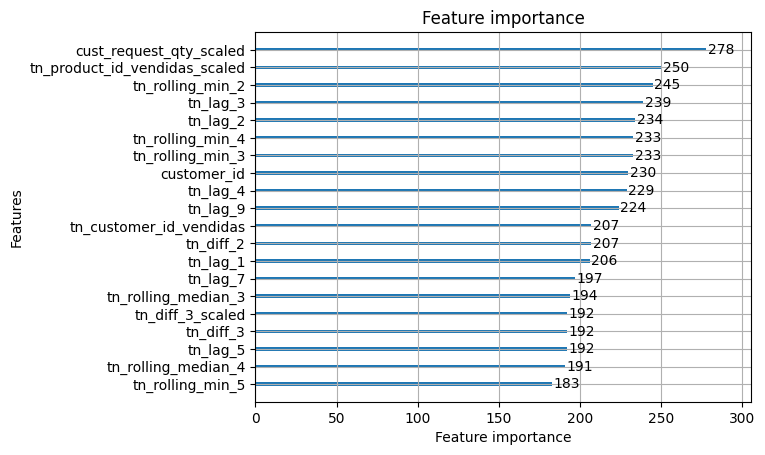

In [6]:
# hago un ensamble de modelos 3 modelos con distintos date_id_start
model_pipeline = Pipeline(
    steps=[
        LoadDataFrameFromPickleStep("df_fe_epic_light.pickle"),
        SplitDataFrameStep2(df="df", test_date=33, gap=1),
        TimeDecayWeghtedProductIdStep(decay_factor=0.99),
        # marco outliers
        #ManualDateIdWeightStep(date_weights={
        #    29: 0.5,
        #    30: 0.7,
        #    31: 0.8
        #}),
        TrainScalerFeatureStep(column="tn"),
        TrainScalerFeatureStep(column="cust_request_qty"),
        TransformScalerFeatureStep(column=r'tn(?!.*(_div_|_per_|_minus_|_prod_))', regex=True, scaler_name="scaler_tn"),
        TransformScalerFeatureStep(column="cust_request_qty", scaler_name="scaler_cust_request_qty"),
        CreateTargetColumStep(target_col="tn_scaled"),
        PrepareXYStep(),
        TrainModelStep(params=params),
        PredictStep(),
        InverseTransformScalerFeatureStep(column="target", scaler_name="scaler_tn"),
        InverseTransformScalerFeatureStep(column="predictions", scaler_name="scaler_tn"),
        EvaluatePredictionsSteps(filter_file="product_id_apredecir201912.txt"),
        PlotFeatureImportanceStep(),
        
    
    ],
    optimize_arftifacts_memory=False,

)
model_pipeline.run() 
models_list.append(model_pipeline) 

Executing step: LoadDataFrameFromPickleStep
Step LoadDataFrameFromPickleStep completed in 0.03 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.17 seconds
Executing step: TimeDecayWeghtedProductIdStep
Step TimeDecayWeghtedProductIdStep completed in 0.01 seconds
Executing step: TrainScalerFeatureStep
Step TrainScalerFeatureStep completed in 0.11 seconds
Executing step: TrainScalerFeatureStep


/home/fede/programacion/labo3/pipeline/steps/processing.py:517: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weight'] = df['date_id'].map(date_weights).fillna(1)


Step TrainScalerFeatureStep completed in 0.11 seconds
Executing step: TransformScalerFeatureStep
Columns found matching regex 'tn(?!.*(_div_|_per_|_minus_|_prod_))': ['cust_request_tn', 'tn', 'cust_request_qty_per_tn', 'cust_request_tn_minus_tn', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_lag_6', 'tn_lag_7', 'tn_lag_8', 'tn_lag_9', 'tn_lag_10', 'tn_lag_11', 'tn_lag_12', 'tn_lag_13', 'tn_lag_14', 'tn_lag_15', 'tn_lag_16', 'tn_lag_17', 'tn_lag_18', 'tn_lag_19', 'tn_lag_20', 'tn_lag_21', 'tn_lag_22', 'tn_lag_23', 'tn_lag_24', 'tn_rolling_2', 'tn_rolling_3', 'tn_rolling_4', 'tn_rolling_5', 'tn_rolling_6', 'tn_rolling_7', 'tn_rolling_8', 'tn_rolling_9', 'tn_rolling_10', 'tn_rolling_11', 'tn_rolling_12', 'tn_rolling_13', 'tn_rolling_14', 'tn_rolling_15', 'tn_rolling_16', 'tn_rolling_17', 'tn_rolling_18', 'tn_rolling_19', 'tn_rolling_20', 'tn_rolling_21', 'tn_rolling_22', 'tn_rolling_23', 'tn_rolling_24', 'tn_rolling_median_2', 'tn_rolling_median_3', 'tn_rolling_median_4'

/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_scaled] = scaler.transform(df[["product_id", column]], column=column)
/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_scaled] = scaler.transform(df[["product_id", column]], column=column)
/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

Step TransformScalerFeatureStep completed in 4.37 seconds
Executing step: TransformScalerFeatureStep
Step TransformScalerFeatureStep completed in 0.01 seconds
Executing step: CreateTargetColumStep


/home/fede/programacion/labo3/pipeline/steps/df_setup.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = df.groupby(['product_id', 'customer_id'])[self.target_col].shift(-2)


Step CreateTargetColumStep completed in 0.32 seconds
Executing step: TransformTargetDiffStep
Step TransformTargetDiffStep completed in 0.00 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.29 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.29 seconds
Executing step: RollingMeanFeatureStep
Step RollingMeanFeatureStep completed in 21.41 seconds
Executing step: RollingMaxFeatureStep
Step RollingMaxFeatureStep completed in 20.88 seconds
Executing step: RollingMinFeatureStep
Step RollingMinFeatureStep completed in 21.22 seconds
Executing step: DiffFeatureStep
Step DiffFeatureStep completed in 0.50 seconds
Executing step: PrepareXYStep
X_train indexes: Index([     0,  17862,  35724,  53586,  71448,  89310, 107172, 125034, 142896,
       160758,
       ...
        17791,  35653,  53515,  71377,  89239, 107101, 124963, 142825, 160687,
       178549],
      dtype='int64', length=158860)
(178620, 674)


/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.356485	valid_0's total_error: 0.255777
[200]	valid_0's l2: 0.359151	valid_0's total_error: 0.231335
[300]	valid_0's l2: 0.366854	valid_0's total_error: 0.212881
[400]	valid_0's l2: 0.371171	valid_0's total_error: 0.199412
[500]	valid_0's l2: 0.374896	valid_0's total_error: 0.220083
[600]	valid_0's l2: 0.372514	valid_0's total_error: 0.214134
[700]	valid_0's l2: 0.375447	valid_0's total_error: 0.207562
[800]	valid_0's l2: 0.374005	valid_0's total_error: 0.221419
[900]	valid_0's l2: 0.376863	valid_0's total_error: 0.23376
[1000]	valid_0's l2: 0.37588	valid_0's total_error: 0.228545
[1100]	valid_0's l2: 0.378445	valid_0's total_error: 0.23786
[1200]	valid_0's l2: 0.382436	valid_0's total_error: 0.248457
[1300]	valid_0's l2: 0.381988	valid_0's total_error: 0.258455
[1400]	valid_0's l2: 0.382265	valid_0's total_error: 0.259254
[1500]	valid_0's l2: 0.384387	valid_0's total_error: 0.254395
[1600]	valid_0's l2: 0.382264	valid_0's total_error: 0.248094
[1700]	valid_0's l2:

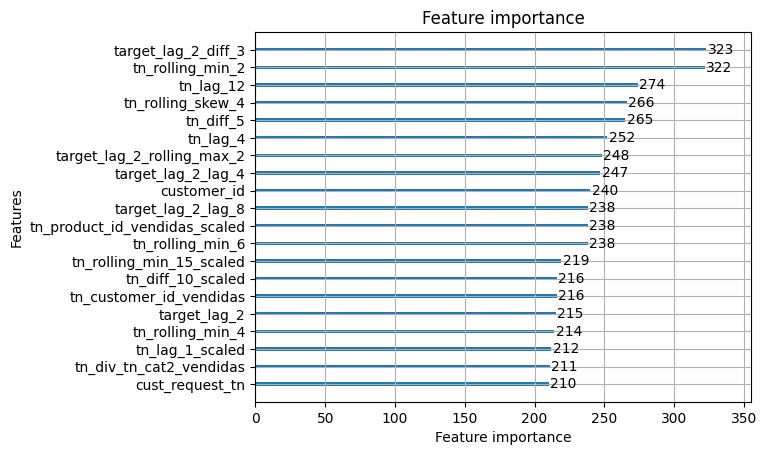

In [8]:
# hago un ensamble de modelos 3 modelos con distintos date_id_start
model_pipeline = Pipeline(
    steps=[
        LoadDataFrameFromPickleStep("df_fe_epic_light.pickle"),
        SplitDataFrameStep2(df="df", test_date=33, gap=1),
        TimeDecayWeghtedProductIdStep(decay_factor=0.99),
        # marco outliers
        #ManualDateIdWeightStep(date_weights={
        #    29: 0.5,
        #    30: 0.7,
        #    31: 0.8
        #}),
        TrainScalerFeatureStep(column="tn"),
        TrainScalerFeatureStep(column="cust_request_qty"),
        TransformScalerFeatureStep(column=r'tn(?!.*(_div_|_per_|_minus_|_prod_))', regex=True, scaler_name="scaler_tn"),
        TransformScalerFeatureStep(column="cust_request_qty", scaler_name="scaler_cust_request_qty"),
        CreateTargetColumStep(target_col="tn_scaled"),
        TransformTargetDiffStep(),
        # creo una columna lag_2 del target que es la serie historica
        FeatureEngineeringLagStep(lags=[2], columns=["target"]),
        # vuelvo a hacer FE de la nueva serie historica :)
        FeatureEngineeringLagStep(lags=list(range(1,25)), columns=["target_lag_2"]),
        RollingMeanFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        #RollingStdFeatureStep(windows=list(range(3,25)), columns=["target_lag_2"]),
        RollingMaxFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        RollingMinFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        #RollingSkewFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        #RollingZscoreFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),

        DiffFeatureStep(periods=list(range(1,25)), columns=["target_lag_2"]),
        PrepareXYStep(),
        TrainModelStep(params=params),
        PredictStep(),
        InverseTransformDiffStep(),
        InverseTransformScalerFeatureStep(column="target", scaler_name="scaler_tn"),
        InverseTransformScalerFeatureStep(column="predictions", scaler_name="scaler_tn"),
        EvaluatePredictionsSteps(filter_file="product_id_apredecir201912.txt"),
        PlotFeatureImportanceStep(),
        
    
    ],
    optimize_arftifacts_memory=False,

)
model_pipeline.run() 
models_list.append(model_pipeline)  

Executing step: LoadDataFrameFromPickleStep
Step LoadDataFrameFromPickleStep completed in 0.10 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.21 seconds
Executing step: TimeDecayWeghtedProductIdStep
Step TimeDecayWeghtedProductIdStep completed in 0.01 seconds
Executing step: TrainScalerFeatureStep
Step TrainScalerFeatureStep completed in 0.10 seconds
Executing step: TrainScalerFeatureStep


/home/fede/programacion/labo3/pipeline/steps/processing.py:517: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weight'] = df['date_id'].map(date_weights).fillna(1)


Step TrainScalerFeatureStep completed in 0.10 seconds
Executing step: TransformScalerFeatureStep
Columns found matching regex 'tn(?!.*(_div_|_per_|_minus_|_prod_))': ['cust_request_tn', 'tn', 'cust_request_qty_per_tn', 'cust_request_tn_minus_tn', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_lag_6', 'tn_lag_7', 'tn_lag_8', 'tn_lag_9', 'tn_lag_10', 'tn_lag_11', 'tn_lag_12', 'tn_lag_13', 'tn_lag_14', 'tn_lag_15', 'tn_lag_16', 'tn_lag_17', 'tn_lag_18', 'tn_lag_19', 'tn_lag_20', 'tn_lag_21', 'tn_lag_22', 'tn_lag_23', 'tn_lag_24', 'tn_rolling_2', 'tn_rolling_3', 'tn_rolling_4', 'tn_rolling_5', 'tn_rolling_6', 'tn_rolling_7', 'tn_rolling_8', 'tn_rolling_9', 'tn_rolling_10', 'tn_rolling_11', 'tn_rolling_12', 'tn_rolling_13', 'tn_rolling_14', 'tn_rolling_15', 'tn_rolling_16', 'tn_rolling_17', 'tn_rolling_18', 'tn_rolling_19', 'tn_rolling_20', 'tn_rolling_21', 'tn_rolling_22', 'tn_rolling_23', 'tn_rolling_24', 'tn_rolling_median_2', 'tn_rolling_median_3', 'tn_rolling_median_4'

/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_scaled] = scaler.transform(df[["product_id", column]], column=column)
/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_scaled] = scaler.transform(df[["product_id", column]], column=column)
/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

Step TransformScalerFeatureStep completed in 5.09 seconds
Executing step: TransformScalerFeatureStep
Step TransformScalerFeatureStep completed in 0.02 seconds
Executing step: CreateTargetColumStep


/home/fede/programacion/labo3/pipeline/steps/df_setup.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = df.groupby(['product_id', 'customer_id'])[self.target_col].shift(-2)


Step CreateTargetColumStep completed in 0.34 seconds
Executing step: TransformTargetLog1pDiffStep
Step TransformTargetLog1pDiffStep completed in 0.01 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.33 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.15 seconds
Executing step: RollingMeanFeatureStep
Step RollingMeanFeatureStep completed in 24.53 seconds
Executing step: RollingMaxFeatureStep
Step RollingMaxFeatureStep completed in 23.51 seconds
Executing step: RollingMinFeatureStep
Step RollingMinFeatureStep completed in 23.73 seconds
Executing step: DiffFeatureStep
Step DiffFeatureStep completed in 0.80 seconds
Executing step: PrepareXYStep
X_train indexes: Index([     0,  17862,  35724,  53586,  71448,  89310, 107172, 125034, 142896,
       160758,
       ...
        17791,  35653,  53515,  71377,  89239, 107101, 124963, 142825, 160687,
       178549],
      dtype='int64', length=158860)
(178

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.169877	valid_0's total_error: 0.470479
[200]	valid_0's l2: 0.171616	valid_0's total_error: 0.458397
[300]	valid_0's l2: 0.171593	valid_0's total_error: 0.452419
[400]	valid_0's l2: 0.173396	valid_0's total_error: 0.472089
[500]	valid_0's l2: 0.174464	valid_0's total_error: 0.476921
[600]	valid_0's l2: 0.174529	valid_0's total_error: 0.455615
[700]	valid_0's l2: 0.175318	valid_0's total_error: 0.454032
[800]	valid_0's l2: 0.176142	valid_0's total_error: 0.462799
[900]	valid_0's l2: 0.176533	valid_0's total_error: 0.463107
[1000]	valid_0's l2: 0.176098	valid_0's total_error: 0.474176
[1100]	valid_0's l2: 0.176882	valid_0's total_error: 0.475562
[1200]	valid_0's l2: 0.177407	valid_0's total_error: 0.477994
[1300]	valid_0's l2: 0.178737	valid_0's total_error: 0.47768
[1400]	valid_0's l2: 0.179146	valid_0's total_error: 0.478285
[1500]	valid_0's l2: 0.17969	valid_0's total_error: 0.483021
[1600]	valid_0's l2: 0.179603	valid_0's total_error: 0.494981
[1700]	valid_0's l2

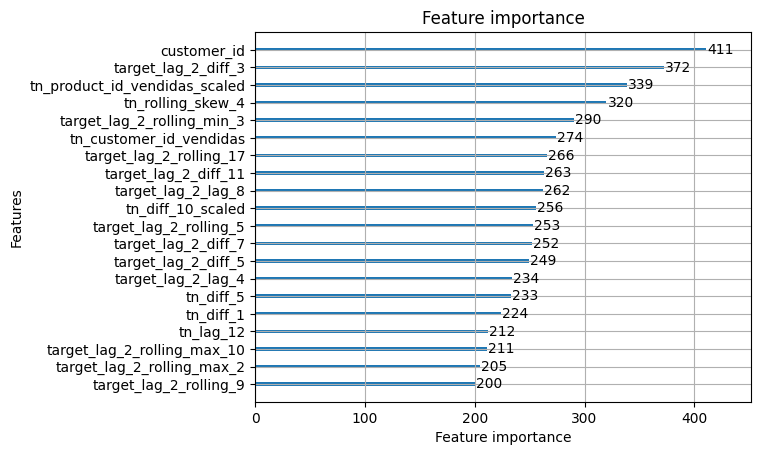

In [9]:
# hago un ensamble de modelos 3 modelos con distintos date_id_start
model_pipeline = Pipeline(
    steps=[
        LoadDataFrameFromPickleStep("df_fe_epic_light.pickle"),
        SplitDataFrameStep2(df="df", test_date=33, gap=1),
        TimeDecayWeghtedProductIdStep(decay_factor=0.99),
        # marco outliers
        #ManualDateIdWeightStep(date_weights={
        #    29: 0.5,
        #    30: 0.7,
        #    31: 0.8
        #}),
        TrainScalerFeatureStep(column="tn"),
        TrainScalerFeatureStep(column="cust_request_qty"),
        TransformScalerFeatureStep(column=r'tn(?!.*(_div_|_per_|_minus_|_prod_))', regex=True, scaler_name="scaler_tn"),
        TransformScalerFeatureStep(column="cust_request_qty", scaler_name="scaler_cust_request_qty"),
        CreateTargetColumStep(target_col="tn"),
        TransformTargetLog1pDiffStep(),
        # creo una columna lag_2 del target que es la serie historica
        FeatureEngineeringLagStep(lags=[2], columns=["target"]),
        # vuelvo a hacer FE de la nueva serie historica :)
        FeatureEngineeringLagStep(lags=list(range(1,25)), columns=["target_lag_2"]),
        RollingMeanFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        #RollingStdFeatureStep(windows=list(range(3,25)), columns=["target_lag_2"]),
        RollingMaxFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        RollingMinFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        #RollingSkewFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        #RollingZscoreFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),

        DiffFeatureStep(periods=list(range(1,25)), columns=["target_lag_2"]),
        PrepareXYStep(),
        TrainModelStep(params=params),
        PredictStep(),
        InverseTransformLog1pDiffStep(),
        #InverseTransformScalerFeatureStep(column="target", scaler_name="scaler_tn"),
        #InverseTransformScalerFeatureStep(column="predictions", scaler_name="scaler_tn"),
        EvaluatePredictionsSteps(filter_file="product_id_apredecir201912.txt"),
        PlotFeatureImportanceStep(),
        
    
    ],
    optimize_arftifacts_memory=False,

)
model_pipeline.run() 
models_list.append(model_pipeline)  

Executing step: LoadDataFrameFromPickleStep
Step LoadDataFrameFromPickleStep completed in 0.04 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.18 seconds
Executing step: TimeDecayWeghtedProductIdStep
Step TimeDecayWeghtedProductIdStep completed in 0.02 seconds
Executing step: TrainScalerFeatureStep
Step TrainScalerFeatureStep completed in 0.10 seconds
Executing step: TrainScalerFeatureStep


/home/fede/programacion/labo3/pipeline/steps/processing.py:517: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weight'] = df['date_id'].map(date_weights).fillna(1)


Step TrainScalerFeatureStep completed in 0.10 seconds
Executing step: TransformScalerFeatureStep
Columns found matching regex 'tn(?!.*(_div_|_per_|_minus_|_prod_))': ['cust_request_tn', 'tn', 'cust_request_qty_per_tn', 'cust_request_tn_minus_tn', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_lag_6', 'tn_lag_7', 'tn_lag_8', 'tn_lag_9', 'tn_lag_10', 'tn_lag_11', 'tn_lag_12', 'tn_lag_13', 'tn_lag_14', 'tn_lag_15', 'tn_lag_16', 'tn_lag_17', 'tn_lag_18', 'tn_lag_19', 'tn_lag_20', 'tn_lag_21', 'tn_lag_22', 'tn_lag_23', 'tn_lag_24', 'tn_rolling_2', 'tn_rolling_3', 'tn_rolling_4', 'tn_rolling_5', 'tn_rolling_6', 'tn_rolling_7', 'tn_rolling_8', 'tn_rolling_9', 'tn_rolling_10', 'tn_rolling_11', 'tn_rolling_12', 'tn_rolling_13', 'tn_rolling_14', 'tn_rolling_15', 'tn_rolling_16', 'tn_rolling_17', 'tn_rolling_18', 'tn_rolling_19', 'tn_rolling_20', 'tn_rolling_21', 'tn_rolling_22', 'tn_rolling_23', 'tn_rolling_24', 'tn_rolling_median_2', 'tn_rolling_median_3', 'tn_rolling_median_4'

/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_scaled] = scaler.transform(df[["product_id", column]], column=column)
/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_scaled] = scaler.transform(df[["product_id", column]], column=column)
/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

Step TransformScalerFeatureStep completed in 4.33 seconds
Executing step: TransformScalerFeatureStep
Step TransformScalerFeatureStep completed in 0.01 seconds
Executing step: CreateTargetColumStep


/home/fede/programacion/labo3/pipeline/steps/scaler.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_scaled] = scaler.transform(df[["product_id", column]], column=column)
/home/fede/programacion/labo3/pipeline/steps/df_setup.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = df.groupby(['product_id', 'customer_id'])[self.target_col].shift(-2)


Step CreateTargetColumStep completed in 0.33 seconds
Executing step: TransformTargetLog1pDiffStep
Step TransformTargetLog1pDiffStep completed in 0.01 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.34 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.14 seconds
Executing step: RollingMeanFeatureStep
Step RollingMeanFeatureStep completed in 21.91 seconds
Executing step: RollingMaxFeatureStep
Step RollingMaxFeatureStep completed in 22.33 seconds
Executing step: RollingMinFeatureStep
Step RollingMinFeatureStep completed in 22.97 seconds
Executing step: DiffFeatureStep
Step DiffFeatureStep completed in 0.87 seconds
Executing step: PrepareXYStep
X_train indexes: Index([     0,  17862,  35724,  53586,  71448,  89310, 107172, 125034, 142896,
       160758,
       ...
        17791,  35653,  53515,  71377,  89239, 107101, 124963, 142825, 160687,
       178549],
      dtype='int64', length=158860)
(178

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.168431	valid_0's total_error: 0.443392
[200]	valid_0's l2: 0.170046	valid_0's total_error: 0.449898
[300]	valid_0's l2: 0.172662	valid_0's total_error: 0.464973
[400]	valid_0's l2: 0.176028	valid_0's total_error: 0.460826
[500]	valid_0's l2: 0.178163	valid_0's total_error: 0.47387
[600]	valid_0's l2: 0.178935	valid_0's total_error: 0.469791
[700]	valid_0's l2: 0.179768	valid_0's total_error: 0.475282
[800]	valid_0's l2: 0.181672	valid_0's total_error: 0.479691
[900]	valid_0's l2: 0.182584	valid_0's total_error: 0.486249
[1000]	valid_0's l2: 0.183172	valid_0's total_error: 0.497591
[1100]	valid_0's l2: 0.183587	valid_0's total_error: 0.497459
[1200]	valid_0's l2: 0.184265	valid_0's total_error: 0.502609
[1300]	valid_0's l2: 0.184926	valid_0's total_error: 0.502738
[1400]	valid_0's l2: 0.185484	valid_0's total_error: 0.501032
[1500]	valid_0's l2: 0.185606	valid_0's total_error: 0.501477
[1600]	valid_0's l2: 0.185499	valid_0's total_error: 0.502824
[1700]	valid_0's l

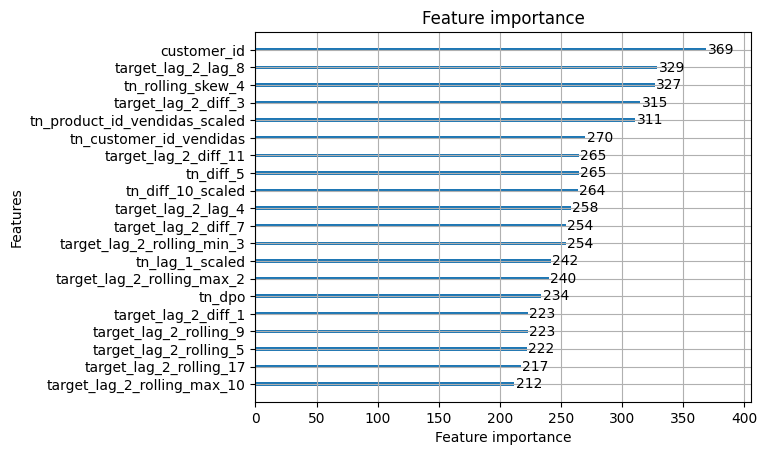

In [10]:
# hago un ensamble de modelos 3 modelos con distintos date_id_start
model_pipeline = Pipeline(
    steps=[
        LoadDataFrameFromPickleStep("df_fe_epic_light.pickle"),
        SplitDataFrameStep2(df="df", test_date=33, gap=1),
        TimeDecayWeghtedProductIdStep(decay_factor=0.99),
        # marco outliers
        #ManualDateIdWeightStep(date_weights={
        #    29: 0.5,
        #    30: 0.7,
        #    31: 0.8
        #}),
        TrainScalerFeatureStep(column="tn"),
        TrainScalerFeatureStep(column="cust_request_qty"),
        TransformScalerFeatureStep(column=r'tn(?!.*(_div_|_per_|_minus_|_prod_))', regex=True, scaler_name="scaler_tn"),
        TransformScalerFeatureStep(column="cust_request_qty", scaler_name="scaler_cust_request_qty"),
        CreateTargetColumStep(target_col="tn"),
        TransformTargetLog1pDiffStep(target_col="tn_rolling_3"),
        # creo una columna lag_2 del target que es la serie historica
        FeatureEngineeringLagStep(lags=[2], columns=["target"]),
        # vuelvo a hacer FE de la nueva serie historica :)
        FeatureEngineeringLagStep(lags=list(range(1,25)), columns=["target_lag_2"]),
        RollingMeanFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        #RollingStdFeatureStep(windows=list(range(3,25)), columns=["target_lag_2"]),
        RollingMaxFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        RollingMinFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        #RollingSkewFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),
        #RollingZscoreFeatureStep(windows=list(range(2,25)), columns=["target_lag_2"]),

        DiffFeatureStep(periods=list(range(1,25)), columns=["target_lag_2"]),
        PrepareXYStep(),
        TrainModelStep(params=params),
        PredictStep(),
        InverseTransformLog1pDiffStep(target_col="tn_rolling_3"),
        #InverseTransformScalerFeatureStep(column="target", scaler_name="scaler_tn"),
        #InverseTransformScalerFeatureStep(column="predictions", scaler_name="scaler_tn"),
        EvaluatePredictionsSteps(filter_file="product_id_apredecir201912.txt"),
        PlotFeatureImportanceStep(),
        
    
    ],
    optimize_arftifacts_memory=False,

)
model_pipeline.run() 
models_list.append(model_pipeline)  

In [17]:
predictions = []
for m in models_list:
    pred = m.get_artifact("eval_df")["tn_pred"]
    print(pred)
    predictions.append(pred)
prom_predictions = sum(predictions) / len(predictions)
prom_predictions

0    1763.368392
1    1129.793319
2     843.781315
3     639.772875
4     516.257995
5     439.217593
6     326.678256
7     377.383956
8     567.331481
9     359.243681
Name: tn_pred, dtype: float64
0    1877.922581
1    1152.652358
2     831.553285
3     631.053281
4     550.687807
5     407.781793
6     340.515227
7     310.768383
8     603.851932
9     385.017917
Name: tn_pred, dtype: float64
0    1349.515421
1     664.889773
2     458.099029
3     427.972788
4     390.669547
5     262.244653
6     230.367601
7     290.288944
8     365.551877
9     215.770589
Name: tn_pred, dtype: float64
0    1047.346368
1     698.995452
2     421.299628
3     457.407206
4     295.003425
5     288.306303
6     200.514009
7     263.077640
8     337.568913
9     213.612635
Name: tn_pred, dtype: float64


0    1509.538191
1     911.582725
2     638.683314
3     539.051537
4     438.154694
5     349.387586
6     274.518773
7     310.379731
8     468.576051
9     293.411206
Name: tn_pred, dtype: float64

In [18]:
eval_df = models_list[3].get_artifact("eval_df").copy()
eval_df["prom_predictions"] = prom_predictions

In [19]:
eval_df

,product_id,target,predictions,tn_real,tn_pred,error_absoluto,prom_predictions
0,20001,1504.651855,1047.346368,1504.651855,1047.346368,457.305487,1509.538191
1,20002,1087.382812,698.995452,1087.382812,698.995452,388.387361,911.582725
2,20003,891.279297,421.299628,891.279297,421.299628,469.979668,638.683314
3,20004,637.875488,457.407206,637.875488,457.407206,180.468282,539.051537
4,20005,592.507324,295.003425,592.507324,295.003425,297.503900,438.154694
5,20006,417.252441,288.306303,417.252441,288.306303,128.946139,349.387586
6,20007,390.525391,200.514009,390.525391,200.514009,190.011382,274.518773
7,20008,195.370605,263.077640,195.370605,263.077640,67.707034,310.379731
8,20009,495.125000,337.568913,495.125000,337.568913,157.556087,468.576051
9,20010,359.704102,213.612635,359.704102,213.612635,146.091466,293.411206


In [20]:
# los prom_predictions que sean menor a 0 los seteo a 0
eval_df["prom_predictions"] = eval_df["prom_predictions"].apply(lambda x: max(x, 0))
eval_df["error_prom_abs"] = np.abs(eval_df["prom_predictions"] - eval_df["tn_real"])
eval_df.sort_values("error_prom_abs", ascending=False, inplace=True)

In [21]:
eval_df

,product_id,target,predictions,tn_real,tn_pred,error_absoluto,prom_predictions,error_prom_abs
2,20003,891.279297,421.299628,891.279297,421.299628,469.979668,638.683314,252.595982
1,20002,1087.382812,698.995452,1087.382812,698.995452,388.387361,911.582725,175.800087
4,20005,592.507324,295.003425,592.507324,295.003425,297.503900,438.154694,154.352631
6,20007,390.525391,200.514009,390.525391,200.514009,190.011382,274.518773,116.006617
7,20008,195.370605,263.077640,195.370605,263.077640,67.707034,310.379731,115.009125
3,20004,637.875488,457.407206,637.875488,457.407206,180.468282,539.051537,98.823951
5,20006,417.252441,288.306303,417.252441,288.306303,128.946139,349.387586,67.864856
9,20010,359.704102,213.612635,359.704102,213.612635,146.091466,293.411206,66.292896
8,20009,495.125000,337.568913,495.125000,337.568913,157.556087,468.576051,26.548949
0,20001,1504.651855,1047.346368,1504.651855,1047.346368,457.305487,1509.538191,4.886335


In [22]:
total_error = np.sum(eval_df["error_prom_abs"]) / np.sum(eval_df["tn_real"])
print(f"Total error: {total_error:.4f}")

Total error: 0.1641
